<a href="https://colab.research.google.com/github/comrademaggie/randomstuff/blob/master/Unsupervised_Learning_on_Trump's_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Table of Contents


>  I. Background

> II. Exploratory Data Analysis

> III. Text Cleaning

>IV. Modeling: TFIDF, LSA, LDA, Clustering


---



# I. BACKGROUND 

This is a text analysis of Trump's twitter feed since October 2018, amounting to 3,653 tweets and 641,888 characters.  We clean the text, stripping punctuations, tokenizing, lemmatizing and stemming with the help of NLTK.  We then vectorize the text to cluster and reduce dimensionality, enabling us to perform basic topic modeling on the text.  

In [0]:
import tweepy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import re
from collections import Counter
pd.set_option('display.max_colwidth', -1)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, words

True

In [0]:
access_token = ''
access_secret = ''
consumer_token = ''
consumer_secret = ''

auth = tweepy.OAuthHandler(consumer_token, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [0]:
since_id = 1142264023825735681
trump = tweepy.Cursor(api.user_timeline, id='realdonaldtrump', tweet_mode='extended', since_id = since_id).items(3200)



In [0]:
# function to extract data from tweet object
def extract_tweet_attributes(tweet_object):
    # create empty list
    tweet_list =[]
    # loop through tweet objects
    for tweet in tweet_object:
        tweet_id = tweet.id # unique integer identifier for tweet
        text = tweet.full_text # utf-8 text of tweet
        favorite_count = tweet.favorite_count
        retweet_count = tweet.retweet_count
        created_at = tweet.created_at # utc time tweet created
        source = tweet.source # utility used to post tweet
        reply_to_status = tweet.in_reply_to_status_id # if reply int of orginal tweet id
        reply_to_user = tweet.in_reply_to_screen_name # if reply original tweetes screenname
            # append attributes to list
        tweet_list.append({'tweet_id':tweet_id, 
                          'text':text, 
                          'favorite_count':favorite_count,
                          'retweet_count':retweet_count,
                          'created_at':created_at, 
                          'source':source, 
                          'reply_to_status':reply_to_status, 
                          'reply_to_user':reply_to_user})
    # create dataframe   
    df = pd.DataFrame(tweet_list, columns=['tweet_id',
                                           'text',
                                           'favorite_count',
                                           'retweet_count',
                                           'created_at',
                                           'source',
                                           'reply_to_status',
                                           'reply_to_user'])
    return df



In [0]:
df_recent = extract_tweet_attributes(trump)
df_recent.head()

,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user
0,1150779375358480390,Here we go with the Fake Polls. Just like what...,57006,14881,2019-07-15 14:49:18,Twitter for iPhone,NaN,None
1,1150766498459394049,.....to impeach President Trump on DAY ONE. Ma...,74144,16978,2019-07-15 13:58:08,Twitter for iPhone,1.150766e+18,realDonaldTrump
2,1150766497469489152,....What does it mean for America to have free...,66312,15197,2019-07-15 13:58:07,Twitter for iPhone,1.150766e+18,realDonaldTrump
3,1150766496462921728,"....they are Anti-Semitic, they are Anti-Ameri...",30249,8515,2019-07-15 13:58:07,Twitter for iPhone,1.150766e+18,realDonaldTrump
4,1150766494697107456,“We all know that AOC and this crowd are a bun...,93724,24062,2019-07-15 13:58:07,Twitter for iPhone,NaN,None


In [0]:
df_recent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 8 columns):
tweet_id           456 non-null int64
text               456 non-null object
favorite_count     456 non-null int64
retweet_count      456 non-null int64
created_at         456 non-null datetime64[ns]
source             456 non-null object
reply_to_status    64 non-null float64
reply_to_user      65 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 28.6+ KB


In [0]:
df_recent.tail()

,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user
451,1142461806935445504,Looking good. We MUST WIN to KEEP AMERICA GREA...,54882,11704,2019-06-22 15:58:15,Twitter for iPhone,NaN,None
452,1142461457495470082,RT @EricTrump: Behind the scenes in #Orlando -...,0,7172,2019-06-22 15:56:52,Twitter for iPhone,NaN,None
453,1142435387496902656,Stock Market is on track to have the best June...,81394,14513,2019-06-22 14:13:16,Twitter for iPhone,NaN,None
454,1142410006513500161,"When people come into our Country illegally, t...",197122,38278,2019-06-22 12:32:25,Twitter for iPhone,NaN,None
455,1142409512240013313,The people that Ice will apprehend have alread...,111159,26772,2019-06-22 12:30:27,Twitter for iPhone,NaN,None


In [0]:
df_recent['tweet_length']=df_recent['text'].str.len()

In [0]:
from google.colab import files
uploaded = files.upload()

Saving trumptweets_2019_06_22_2019_07_15.csv to trumptweets_2019_06_22_2019_07_15.csv


In [0]:
import io
tweets = pd.read_csv(io.BytesIO(uploaded['trumptweets_2019_06_22_2019_07_15.csv']))
# Dataset is now stored in a Pandas Dataframe

In [0]:
tweets = pd.concat([df_recent, df1])
tweets.head()

,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user,tweet_length
0,1150779375358480390,Here we go with the Fake Polls. Just like what...,57006,14881,2019-07-15 14:49:18,Twitter for iPhone,NaN,None,234
1,1150766498459394049,.....to impeach President Trump on DAY ONE. Ma...,74144,16978,2019-07-15 13:58:08,Twitter for iPhone,1.150766e+18,realDonaldTrump,214
2,1150766497469489152,....What does it mean for America to have free...,66312,15197,2019-07-15 13:58:07,Twitter for iPhone,1.150766e+18,realDonaldTrump,280
3,1150766496462921728,"....they are Anti-Semitic, they are Anti-Ameri...",30249,8515,2019-07-15 13:58:07,Twitter for iPhone,1.150766e+18,realDonaldTrump,279
4,1150766494697107456,“We all know that AOC and this crowd are a bun...,93724,24062,2019-07-15 13:58:07,Twitter for iPhone,NaN,None,280


In [0]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3653 entries, 0 to 3196
Data columns (total 9 columns):
tweet_id           3653 non-null int64
text               3653 non-null object
favorite_count     3653 non-null int64
retweet_count      3653 non-null int64
created_at         3653 non-null object
source             3653 non-null object
reply_to_status    219 non-null float64
reply_to_user      223 non-null object
tweet_length       3653 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 285.4+ KB


In [0]:
from google.colab import files
tweets.to_csv('trumptweets_2019_06_22_2019_07_15.csv') 
files.download('trumptweets_2019_06_22_2019_07_15.csv')


In [0]:
#how large is the corpus of text? <1M word count
tweets.tweet_length.sum()

641888

In [0]:
tweets['clean_text'] = tweets['text'].apply(lambda x: ' '.join([word.lower() for word in str(x).split()]))
tweets.head()

,Unnamed: 0,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user,tweet_length,clean_text
0,0,1.150780e+18,"Here we go with the Fake Polls. Just like what happened with the Election against Crooked Hillary Clinton. ABC, NBC, CNN, @nytimes, @washingtonpost, they all got it wrong, on purpose. Suppression Polls so early? They will never learn!",57006,14881,15/07/2019 14:49,Twitter for iPhone,NaN,NaN,234,"here we go with the fake polls. just like what happened with the election against crooked hillary clinton. abc, nbc, cnn, @nytimes, @washingtonpost, they all got it wrong, on purpose. suppression polls so early? they will never learn!"
1,1,1.150770e+18,".....to impeach President Trump on DAY ONE. Make them the face of the future of the Democrat Party, you will destroy the Democrat Party. Their policies will destroy our Country!” @LindseyGrahamSC Need I say more?",74144,16978,15/07/2019 13:58,Twitter for iPhone,1.150000e+18,realDonaldTrump,214,".....to impeach president trump on day one. make them the face of the future of the democrat party, you will destroy the democrat party. their policies will destroy our country!” @lindseygrahamsc need i say more?"
2,2,1.150770e+18,"....What does it mean for America to have free Healthcare for Illegal Immigrants, no criminalization of coming into our Country - See how that works for controlling Immigration! They talk about Israel like they’re a bunch of thugs, not victims of the entire region. They wanted...",66312,15197,15/07/2019 13:58,Twitter for iPhone,1.150000e+18,realDonaldTrump,280,"....what does it mean for america to have free healthcare for illegal immigrants, no criminalization of coming into our country - see how that works for controlling immigration! they talk about israel like they’re a bunch of thugs, not victims of the entire region. they wanted..."
3,3,1.150770e+18,"....they are Anti-Semitic, they are Anti-America, we don’t need to know anything about them personally, talk about their policies. I think they are American citizens who are duly elected that are running on an agenda that is disgusting, that the American people will reject......",30249,8515,15/07/2019 13:58,Twitter for iPhone,1.150000e+18,realDonaldTrump,279,"....they are anti-semitic, they are anti-america, we don’t need to know anything about them personally, talk about their policies. i think they are american citizens who are duly elected that are running on an agenda that is disgusting, that the american people will reject......"
4,4,1.150770e+18,"“We all know that AOC and this crowd are a bunch of Communists, they hate Israel, they hate our own Country, they’re calling the guards along our Border (the Border Patrol Agents) Concentration Camp Guards, they accuse people who support Israel as doing it for the Benjamin’s,....",93724,24062,15/07/2019 13:58,Twitter for iPhone,NaN,NaN,280,"“we all know that aoc and this crowd are a bunch of communists, they hate israel, they hate our own country, they’re calling the guards along our border (the border patrol agents) concentration camp guards, they accuse people who support israel as doing it for the benjamin’s,...."


# II. Exploratory Data Analysis

Trump's Chistmas tweet is is most favorited tweet at 491,115 likes.  

Trump's most retweeted tweet is a Game of Thrones meme from April 2019 in response to the Mueller report of "no collusion."  

Trump predominantly tweets from an iPhone, with just 49 of the 3653 tweets coming from "Twitter Media Studio" and 1 from an iPad. 

In [0]:
tweets_top_5 = tweets.nlargest(5, ['favorite_count']) 
tweets_top_5[['text', 'favorite_count', 'created_at']] 

,text,favorite_count,created_at
2902,Merry Christmas!,491115,25/12/2018 12:59
1940,"Good Morning, Have A Great Day!",455015,24/03/2019 12:01
1938,"No Collusion, No Obstruction, Complete and Total EXONERATION. KEEP AMERICA GREAT!",402739,24/03/2019 20:42
1648,https://t.co/222atp7wuB,395481,18/04/2019 13:57
1939,MAKE AMERICA GREAT AGAIN!,338813,24/03/2019 12:02


In [0]:
retweets_top_5 = tweets.nlargest(5, ['retweet_count']) 
retweets_top_5[['text', 'retweet_count', 'created_at']] 

,text,retweet_count,created_at
1648,https://t.co/222atp7wuB,114708,18/04/2019 13:57
1725,WE WILL NEVER FORGET! https://t.co/VxrGFRFeJM,97597,12/04/2019 21:35
1194,RT @DonaldJTrumpJr: Very proud to have a President do what what he said he was going to do. For decades now @realdonaldtrump has been signa…,96080,11/05/2019 12:04
1933,"RT @realDonaldTrump: No Collusion, No Obstruction, Complete and Total EXONERATION. KEEP AMERICA GREAT!",93442,25/03/2019 10:26
1938,"No Collusion, No Obstruction, Complete and Total EXONERATION. KEEP AMERICA GREAT!",93442,24/03/2019 20:42


In [0]:
set(tweets['source'])

{'Twitter Media Studio', 'Twitter for iPad', 'Twitter for iPhone'}

In [0]:
tweets['source'].value_counts()

Twitter for iPhone      3603
Twitter Media Studio    49  
Twitter for iPad        1   
Name: source, dtype: int64

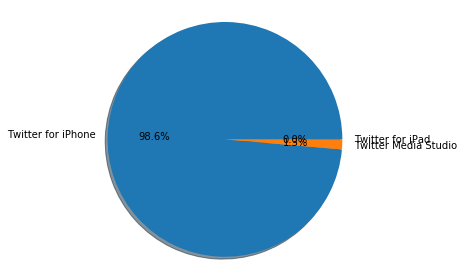

In [0]:
labels = ['Twitter for iPhone', 'Twitter Media Studio', 'Twitter for iPad']
sizes = [3603, 49, 1]


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

In [0]:
tfav = pd.Series(data=tweets['favorite_count'].values, index=tweets['created_at'])
tret = pd.Series(data=tweets['retweet_count'].values, index=tweets['created_at'])

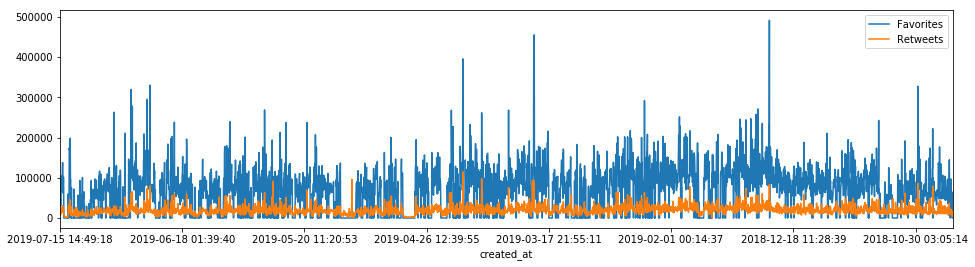

In [0]:
tfav.plot(figsize=(16,4), label="Favorites", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);

# III. Text Cleaning 

We first create functions to strip emojis, punctuations, non-latin text, and digits.  We then strip stop words, tokenize and lemmatize the tweets.  After seeing that there were lots of duplicate words like fulfill and fulfilling, the stemming function was also added. NLTK Snowball stemming was used as a more "sophisticated" alternative to Porter.

To improve upon the models, additional text cleaning should be performed to strip out proper nouns and check words against English dictionary of words.  

A WordCloud is generated for the tweets that have been tokenized and lemmatized.  This gives a quick visualization of some of the most frequently occurring words in Trump's tweets. 

In [0]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [0]:
def clean_tweets(tweet):
 #remove URLs
    tweet = re.sub("http\S+", "", tweet)
 #remove handles, punctuation, emojis 
    tweet = re.sub("(rt)*\s*@[\w]*", "", tweet) #how to get rid of apostrophe s case
    tweet = re.sub("#[\w]*", "", tweet) #remove hashtags
    tweet = re.sub("'[\w]*", "", tweet)
    tweet = re.sub("[/$=&%’‘|…~\+\“\”*,\[\\\'\":\]\(\)\-\—\–]", "", tweet) #remove punctuation
    tweet = re.sub("(&amp;)*", "", tweet) #remove ampersand
    tweet = re.sub("(amp)", "", tweet) #remove ampersand
    tweet = re.sub("\s*(\d*\:*\d*\s?(?:AM|PM|am|pm))", "", tweet) #remove pm
    tweet = re.sub("[\d]*", "", tweet)  #remove digits
    tweet = re.sub("[\.!?;]*", "", tweet) #remove additional punctuation
    tweet = emoji_pattern.sub(r'', tweet) #remove emojis specified above
    tweet = re.sub("[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]", "", tweet) #remove non-latin text
    return tweet

In [0]:
tweets['tweet_cleaner']=tweets['clean_text'].apply(lambda x:clean_tweets(x))

In [0]:
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

stop_words = set(stopwords.words('english'))
  
lemmatizer = WordNetLemmatizer() 


tknzr = TweetTokenizer(reduce_len=True)

def token_lemmatizer(text):
    tweet_tokens = tknzr.tokenize(text)
    
    lemmas = []
 
    for token in tweet_tokens:
        if token not in stop_words:
            lemmas.append(lemmatizer.lemmatize(token))
    return lemmas


In [0]:
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')


stop_words = set(stopwords.words('english'))
  
lemmatizer = WordNetLemmatizer() 



tknzr = TweetTokenizer(reduce_len=True)

def token_lemmatizer_stemmer(text):
    tweet_tokens = tknzr.tokenize(text)
    
    lemmas = []
 
    for token in tweet_tokens:
        if token not in stop_words:
            lemmas.append(lemmatizer.lemmatize(stemmer.stem(token)))
    return lemmas


In [0]:
tweets['tweet_token_lemma']=tweets['tweet_cleaner'].apply(lambda x:token_lemmatizer(x))
tweets['tweet_token_lemma_stem']=tweets['tweet_cleaner'].apply(lambda x:token_lemmatizer_stemmer(x))
tweets.head()

,Unnamed: 0,tweet_id,text,favorite_count,retweet_count,created_at,source,reply_to_status,reply_to_user,tweet_length,clean_text,tweet_cleaner,tweet_token_lemma,tweet_token_lemma_stem
0,0,1.150780e+18,"Here we go with the Fake Polls. Just like what happened with the Election against Crooked Hillary Clinton. ABC, NBC, CNN, @nytimes, @washingtonpost, they all got it wrong, on purpose. Suppression Polls so early? They will never learn!",57006,14881,15/07/2019 14:49,Twitter for iPhone,NaN,NaN,234,"here we go with the fake polls. just like what happened with the election against crooked hillary clinton. abc, nbc, cnn, @nytimes, @washingtonpost, they all got it wrong, on purpose. suppression polls so early? they will never learn!",here we go with the fake polls just like what happened with the election against crooked hillary clinton abc nbc cnn they all got it wrong on purpose suppression polls so early they will never learn,"[go, fake, poll, like, happened, election, crooked, hillary, clinton, abc, nbc, cnn, got, wrong, purpose, suppression, poll, early, never, learn]","[go, fake, poll, like, happen, elect, crook, hillari, clinton, abc, nbc, cnn, got, wrong, purpos, suppress, poll, earli, never, learn]"
1,1,1.150770e+18,".....to impeach President Trump on DAY ONE. Make them the face of the future of the Democrat Party, you will destroy the Democrat Party. Their policies will destroy our Country!” @LindseyGrahamSC Need I say more?",74144,16978,15/07/2019 13:58,Twitter for iPhone,1.150000e+18,realDonaldTrump,214,".....to impeach president trump on day one. make them the face of the future of the democrat party, you will destroy the democrat party. their policies will destroy our country!” @lindseygrahamsc need i say more?",to impeach president trump on day one make them the face of the future of the democrat party you will destroy the democrat party their policies will destroy our country need i say more,"[impeach, president, trump, day, one, make, face, future, democrat, party, destroy, democrat, party, policy, destroy, country, need, say]","[impeach, presid, trump, day, one, make, face, futur, democrat, parti, destroy, democrat, parti, polici, destroy, countri, need, say]"
2,2,1.150770e+18,"....What does it mean for America to have free Healthcare for Illegal Immigrants, no criminalization of coming into our Country - See how that works for controlling Immigration! They talk about Israel like they’re a bunch of thugs, not victims of the entire region. They wanted...",66312,15197,15/07/2019 13:58,Twitter for iPhone,1.150000e+18,realDonaldTrump,280,"....what does it mean for america to have free healthcare for illegal immigrants, no criminalization of coming into our country - see how that works for controlling immigration! they talk about israel like they’re a bunch of thugs, not victims of the entire region. they wanted...",what does it mean forerica to have free healthcare for illegal immigrants no criminalization of coming into our country see how that works for controlling immigration they talk about israel like theyre a bunch of thugs not victims of the entire region they wanted,"[mean, forerica, free, healthcare, illegal, immigrant, criminalization, coming, country, see, work, controlling, immigration, talk, israel, like, theyre, bunch, thug, victim, entire, region, wanted]","[mean, forerica, free, healthcar, illeg, immigr, crimin, come, countri, see, work, control, immigr, talk, israel, like, theyr, bunch, thug, victim, entir, region, want]"
3,3,1.150770e+18,"....they are Anti-Semitic, they are Anti-America, we don’t need to know anything about them personally, talk about their policies. I think they are American citizens who are duly elected that are running on an agenda that is disgusting, that the American people will reject......",30249,8515,15/07/2019 13:58,Twitter for iPhone,1.150000e+18,realDonaldTrump,279,"....they are anti-semitic, they are anti-america, we don’t need to know anything about them personally, talk about

In [0]:
#filtering out empty rows
tweets = tweets.loc[tweets['tweet_token_lemma'].apply(len)>0,:]
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3515 entries, 0 to 3652
Data columns (total 14 columns):
Unnamed: 0                3515 non-null int64
tweet_id                  3515 non-null float64
text                      3515 non-null object
favorite_count            3515 non-null int64
retweet_count             3515 non-null int64
created_at                3515 non-null object
source                    3515 non-null object
reply_to_status           218 non-null float64
reply_to_user             222 non-null object
tweet_length              3515 non-null int64
clean_text                3515 non-null object
tweet_cleaner             3515 non-null object
tweet_token_lemma         3515 non-null object
tweet_token_lemma_stem    3515 non-null object
dtypes: float64(2), int64(4), object(8)
memory usage: 411.9+ KB


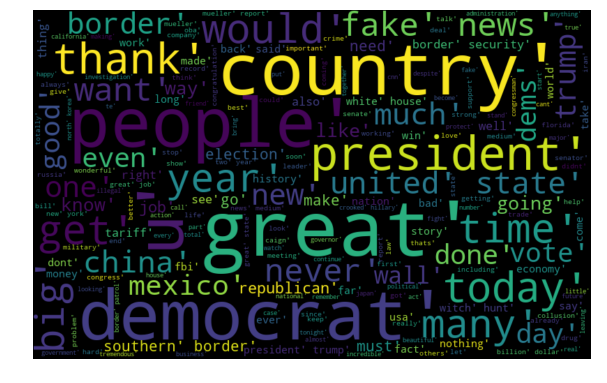

In [0]:
from wordcloud import WordCloud

all_words = ' '.join([str(text) for text in tweets['tweet_token_lemma']])


wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#IV. Modeling: TFIDF, LSA, LDA, Clustering

TFIDF is used to "vectorize" the words and then further topic modeling is done through Latent Semantic Analysis, a dimensionality-reducing algorithm.  What is interesting about this process is that almost 90% of the variance in the dataset can be explained with just 1500 features.  This seems to suggest either Trump does not have a broad vocabulary or has adhered to a repeated message set in the last 6 months.

We can also use TruncatedSVD to reduce the dimensionality of TFIDF to 2 components, enabling us to visualize the data.  This is an improvement on the WordCloud, as words like "thank", "border", "great", and "democrat" seem to emerge even more strongly and suggest Trump's penchant for exaggeration.  

The tweets that get grouped together by LSA seem to indicate the model is working.  The topics that are extracted, though copious at 1500 topics, do seem to group together similar subject matter.  

Using two different dimensionality reduction algorthims, LSA and LDA, and clustering on TFIDF Vectorized text, similar topics emerge.  This is very interesting as it seems to indicate there is some underlying truth to by vectorizing and grouping words.  However, the clustering exercise is unsatisfactory as there is no metric for evaluation.  Silhouette scores are quite low, which makes sense given most of the words are very closely grouped together, not allowing very distinct clusters to emerge.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

In [0]:
docs= tweets['tweet_token_lemma'].tolist()
docs_stem = tweets['tweet_token_lemma_stem'].tolist()

In [0]:
tfidf.fit(docs_stem)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2',
                preprocessor=<function dummy_fun at 0x7fc04045e598>,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern=None,
                tokenizer=<function dummy_fun at 0x7fc04045e598>, use_idf=True,
                vocabulary=None)

In [0]:
X_tfidf = tfidf.fit_transform(docs_stem)
print("Number of features: %d" % X_tfidf.get_shape()[1])

Number of features: 5594


In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#90% of variance captured with 1500 features
svd= TruncatedSVD(1500)


X_lsa = svd.fit_transform(X_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)




Percent variance captured by all components: 89.57359937774815


In [0]:
feature_count = [100, 500, 1000, 1500, 2000, 2500, 3000]
total_variance = []
for num in feature_count:
    svd=TruncatedSVD(num)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    X_lsa = lsa.fit_transform(X_tfidf)
    variance_explained=svd.explained_variance_ratio_
    total_variance.append(variance_explained.sum())

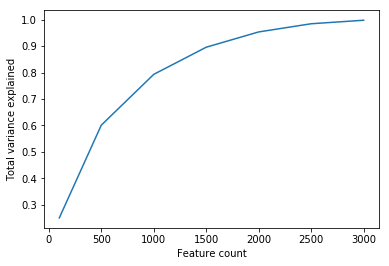

In [0]:
plt.plot(feature_count,total_variance)
plt.xlabel('Feature count')
plt.ylabel('Total variance explained')
plt.show()

In [0]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

svd_2d = TruncatedSVD(n_components=2)
words_2d = svd_2d.fit_transform(X_tfidf.T)
 
df_2d = pd.DataFrame(columns=['x', 'y', 'word'])
df_2d['x'], df_2d['y'], df_2d['word'] = words_2d[:,0], words_2d[:,1], tfidf.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df_2d))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

Loading BokehJS ...

In [0]:
tweets_by_component=pd.DataFrame(X_lsa,index=tweets)
for i in range(5):
    print('Component {}:'.format(i))
    print(tweets_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Component 0:
(1106611696548884480, I’d like to thank all of the Great Republican Senators who bravely voted for Strong Border Security and the WALL. This will help stop Crime, Human Trafficking, and Drugs entering our Country. Watch, when you get back to your State, they will LOVE you more than ever before!, 129809, 28471, 2019-03-15 17:42:42, Twitter for iPhone, nan, nan, 273, i’d like to thank all of the great republican senators who bravely voted for strong border security and the wall. this will help stop crime, human trafficking, and drugs entering our country. watch, when you get back to your state, they will love you more than ever before!, id like to thank all of the great republican senators who bravely voted for strong border security and the wall this will help stop crime human trafficking and drugs entering our country watch when you get back to your state they will love you more than ever before, [id, like, thank, great, republican, senator, bravely, voted, strong, border,

In [0]:
def print_topics(model, vectorizer, top_n=5):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

print("LSA Model:")
print_topics(svd, tfidf)

LSA Model:
Topic 0:
[('great', 0.26817109752244694), ('border', 0.2403207501274116), ('thank', 0.2266934630272572), ('democrat', 0.17653616186375223), ('presid', 0.15337729156640156)]
Topic 1:
[('thank', 0.9366050682050131), ('great', 0.06749023065618949), ('hard', 0.0661305738322704), ('work', 0.05430463857506857), ('makeerica', 0.03182494601991014)]
Topic 2:
[('border', 0.4586951972926836), ('wall', 0.25412511056125836), ('secur', 0.2043229983056183), ('southern', 0.16849757749218341), ('democrat', 0.16296675740872213)]
Topic 3:
[('great', 0.577726797649049), ('makeerica', 0.28160959369692057), ('border', 0.2013838112755964), ('job', 0.12951599551705503), ('vote', 0.11410141060731459)]
Topic 4:
[('china', 0.29093003972832526), ('u', 0.19770795076701883), ('tariff', 0.19661226006190724), ('mexico', 0.17445379316245763), ('unit', 0.1691404390311583)]
Topic 5:
[('news', 0.4121284306302823), ('fake', 0.3459253987363856), ('medium', 0.18896329323234987), ('border', 0.10722020625191603), (

In [0]:
docs_stem_2 = [str(item).lower() for item in docs_stem]


In [0]:
!pip install lda

     |████████████████████████████████| 358kB 24.0MB/s 
     |████████████████████████████████| 102kB 30.1MB/s 


In [0]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 15 # number of topics
n_iter = 500 # number of iterations

# # vectorizer: ignore English stopwords & words that occur less than 5 times
cvectorizer = CountVectorizer(min_df=5)
cvz = cvectorizer.fit_transform(docs_stem_2).toarray()

# train an LDA model
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

INFO:lda:n_documents: 3515
INFO:lda:vocab_size: 1672
INFO:lda:n_words: 46738
INFO:lda:n_topics: 15
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -546755
INFO:lda:<10> log likelihood: -367733
INFO:lda:<20> log likelihood: -352915
INFO:lda:<30> log likelihood: -346879
INFO:lda:<40> log likelihood: -343385
INFO:lda:<50> log likelihood: -341540
INFO:lda:<60> log likelihood: -339724
INFO:lda:<70> log likelihood: -338532
INFO:lda:<80> log likelihood: -337777
INFO:lda:<90> log likelihood: -337486
INFO:lda:<100> log likelihood: -336679
INFO:lda:<110> log likelihood: -336365
INFO:lda:<120> log likelihood: -335536
INFO:lda:<130> log likelihood: -335017
INFO:lda:<140> log likelihood: -334884
INFO:lda:<150> log likelihood: -334415
INFO:lda:<160> log likelihood: -334339
INFO:lda:<170> log likelihood: -334676
INFO:lda:<180> log likelihood: -334802
INFO:lda:<190> log likelihood: -334700
INFO:lda:<200> log likelihood: -334301
INFO:lda:<210> log likelihood: -334080
INFO:lda:<220> log likelihood: -3

In [0]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# 20-D -> 2-D
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3515 samples in 0.004s...
[t-SNE] Computed neighbors for 3515 samples in 0.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3515
[t-SNE] Computed conditional probabilities for sample 2000 / 3515
[t-SNE] Computed conditional probabilities for sample 3000 / 3515
[t-SNE] Computed conditional probabilities for sample 3515 / 3515
[t-SNE] Mean sigma: 0.118307
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.956512
[t-SNE] KL divergence after 1000 iterations: 1.197352


In [0]:
n_top_words = 10
topic_summaries = []
topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [0]:
topic_summaries

['justic court play presid never big ge bill let state',
 'democrat republican vote senat parti secur border win nanci need',
 'news fake medium peopl stori time report new never go',
 'hous back white democrat go want come work peopl time',
 'china deal tariff trade state dollar billion make unit good',
 'presid year last trump look korea joe two north biden',
 'great vote get state florida thank strong job big endors',
 'great new look announc forward job unit wonder secretari interview',
 'fbi hillari clinton caign crook trump oba lawyer russia comey',
 'border wall mexico secur southern immigr illeg countri democrat law',
 'mueller collus democrat report hunt witch never crime obstruct dem',
 'get mani countri would back take year like want new',
 'economi job presid trump year best great first record number',
 'great today thank nation honor day presid one world woman',
 'peopl presid state trump thank work great stand california law']

In [0]:
len(cvectorizer.get_feature_names())

1672

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize


Xn_tfidf = normalize(X_tfidf)

clusters = list(range(5,35,10))
for number in clusters:
    km = KMeans(n_clusters = number).fit(Xn_tfidf)
    Xn_labels = km.labels_
    X_silhouette = metrics.silhouette_score(Xn_tfidf, Xn_labels, metric='euclidean')
    print('Clusters: {}, Silhouette: {}'.format(number, X_silhouette))

Clusters: 5, Silhouette: 0.00728531203617611
Clusters: 15, Silhouette: 0.01039146592061624
Clusters: 25, Silhouette: 0.013952994260452888


In [0]:
words = tfidf.get_feature_names()
kmeans = KMeans(n_clusters = 15, n_init = 5, n_jobs = -1)
kmeans.fit(Xn_tfidf)
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : china, tariff, deal, u, product, trade, mexico, billion, buy, pay
1 : mueller, collus, report, obstruct, democrat, investig, harass, hillari, fbi, presidenti
2 : presid, trump, thank, mr, donald, oba, first, happen, impeach, day
3 : today, honor, great, welcom, day, nation, hero, celebr, u, new
4 : border, wall, secur, southern, democrat, crisi, crime, build, drug, countri
5 : news, fake, medium, stori, peopl, enemi, great, report, corrupt, time
6 : great, job, makeerica, state, endors, vet, militari, fantast, love, total
7 : immigr, illeg, law, mexico, border, come, must, democrat, countri, u
8 : great, peopl, countri, state, trump, get, time, new, big, want
9 : hunt, witch, mueller, continu, hoax, collus, never, phoni, start, democrat
10 : thank, hard, work, great, much, ari, franklin, night, honor, texa
11 : interview, enjoy, tonight, pm, watch, live, eastern, crowd, join, massiv
12 : year, two, mani, best, last, presid, first, great, ago, administr
13 : vote, republican, parti,